# The dataset contains information about Traffic city with the following columns:

`City`: The name of the city where the data is collected. Example: "SolarisVille," "AquaCity," etc.

`Vehicle Type`: The type of vehicle being analyzed. Examples include "Drone," "Flying Car," "Autonomous Vehicle."

`Weather`: The weather condition during the data collection. Examples include "Snowy," "Solar Flare," "Clear."

`Economic Condition`: The economic state of the city or region at the time of data collection. Examples include "Stable," "Recession," "Booming."

`Day Of Week`: The day of the week when the data was recorded. Example: "Sunday," "Wednesday," "Thursday."

`Hour Of Day`: The hour during the day when the data was collected, in a 24-hour format. Example: 20 (8 PM), 2 (2 AM).

`Speed`: The speed of the vehicle at the time of data collection, likely in units like km/h or mph. Example: 29.4268, 118.8000.

`Is Peak Hour`: A binary indicator (likely 0 or 1) representing whether the time corresponds to a peak traffic hour. Example: 0 (not a peak hour), 1 (peak hour).

`Random Event Occurred`: A binary indicator (0 or 1) representing whether a random event (e.g., an accident or unusual traffic condition) occurred. Example: 0 (no event), 1 (event occurred).

`Energy Consumption`: The amount of energy consumed by the vehicle, possibly in units like kilowatt-hours (kWh). Example: 14.7134, 143.5682.

`Traffic Density`: A measure of how dense the traffic is in the area, possibly represented as a ratio or percentage. Example: 0.5241, 0.3208.

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


## Load the Data

In [2]:
import sqlite3
import pandas as pd

# Step 1: Load your data into a Pandas DataFrame
# Replace 'your_data.csv' with the path to your CSV file
df = pd.read_csv('/content/city-traffic.csv')

df.rename(columns={
    'Vehicle Type': 'Vehicle_Type',  # Adjust this based on your actual column names
    'Economic Condition': 'Economic_Condition',
    'Day Of Week': 'Day_Of_Week',
    'Is Peak Hour': 'Is_Peak_Hour',
    'Random Event Occurred': 'Random_Event_Occurred',
    'Energy Consumption': 'Energy_Consumption',
    'Traffic Density': 'Traffic_Density'
}, inplace=True)


# Step 2: Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('traffic_data.db')
cursor = conn.cursor()

# Step 3: Create table if it doesn’t exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS traffic_data (
    data_index INTEGER PRIMARY KEY AUTOINCREMENT,
    City TEXT,
    Vehicle_Type TEXT,
    Weather TEXT,
    Economic_Condition TEXT,
    Day_Of_Week TEXT,
    Hour_Of_Day INTEGER,
    Speed REAL,
    Is_Peak_Hour INTEGER,
    Random_Event_Occurred INTEGER,
    Energy_Consumption REAL,
    Traffic_Density REAL
)
''')
# Drop the existing table (if necessary)
cursor.execute('DROP TABLE IF EXISTS traffic_data')



# Step 4: Insert data into the table
# Using `executemany` for bulk insertions
df.to_sql('traffic_data', conn, if_exists='append', index=False)

# Commit changes and close the connection
conn.commit()
conn.close()

print("Data successfully inserted into the SQLite database.")

Data successfully inserted into the SQLite database.


  ## Exploratory Data Analysis (EDA)

In [3]:
df.head()

,City,Vehicle_Type,Weather,Economic_Condition,Day_Of_Week,Hour Of Day,Speed,Is_Peak_Hour,Random_Event_Occurred,Energy_Consumption,Traffic_Density
0,SolarisVille,Drone,Snowy,Stable,Sunday,20,29.4268,0,0,14.7134,0.5241
1,AquaCity,Flying Car,Solar Flare,Recession,Wednesday,2,118.8000,0,0,143.5682,0.3208
2,Neuroburg,Autonomous Vehicle,Solar Flare,Recession,Wednesday,16,100.3904,0,0,91.2640,0.0415
3,Ecoopolis,Drone,Clear,Booming,Thursday,8,76.8000,1,0,46.0753,0.1811
4,AquaCity,Autonomous Vehicle,Solar Flare,Stable,Saturday,16,45.2176,0,0,40.1934,0.4544


In [4]:
df.sample()

,City,Vehicle_Type,Weather,Economic_Condition,Day_Of_Week,Hour Of Day,Speed,Is_Peak_Hour,Random_Event_Occurred,Energy_Consumption,Traffic_Density
44945,AquaCity,Autonomous Vehicle,Solar Flare,Recession,Thursday,12,67.1088,0,1,53.687,0.2261


In [5]:
df.tail()

,City,Vehicle_Type,Weather,Economic_Condition,Day_Of_Week,Hour Of Day,Speed,Is_Peak_Hour,Random_Event_Occurred,Energy_Consumption,Traffic_Density
99996,Neuroburg,Drone,Clear,Booming,Saturday,23,45.9703,0,1,26.1195,0.1271
99997,MetropolisX,Drone,Snowy,Recession,Monday,17,103.1258,1,0,49.3425,0.2779
99998,MetropolisX,Autonomous Vehicle,Clear,Booming,Friday,9,65.7362,0,0,52.5889,0.7118
99999,TechHaven,Autonomous Vehicle,Electromagnetic Storm,Recession,Friday,23,17.4798,0,0,16.7271,0.0732
100000,MetropolisX,Autonomous Vehicle,Clear,Booming,Wednesday,6,80.9438,0,0,73.5853,0.3777


In [6]:
df.shape

(100001, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   City                   100001 non-null  object 
 1   Vehicle_Type           100001 non-null  object 
 2   Weather                100001 non-null  object 
 3   Economic_Condition     100001 non-null  object 
 4   Day_Of_Week            100001 non-null  object 
 5   Hour Of Day            100001 non-null  int64  
 6   Speed                  100001 non-null  float64
 7   Is_Peak_Hour           100001 non-null  int64  
 8   Random_Event_Occurred  100001 non-null  int64  
 9   Energy_Consumption     100001 non-null  float64
 10  Traffic_Density        100001 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 8.4+ MB


In [8]:
print(df.groupby('Vehicle_Type').size())

Vehicle_Type
Autonomous Vehicle    61915
Car                    6361
Drone                 25101
Flying Car             6624
dtype: int64


In [9]:
df = df[df['Vehicle_Type'] != 'Flying Car']

In [10]:
print(df.groupby('Vehicle_Type').size())

Vehicle_Type
Autonomous Vehicle    61915
Car                    6361
Drone                 25101
dtype: int64


In [11]:
df = df.drop(columns=['Economic_Condition'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93377 entries, 0 to 100000
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   93377 non-null  object 
 1   Vehicle_Type           93377 non-null  object 
 2   Weather                93377 non-null  object 
 3   Day_Of_Week            93377 non-null  object 
 4   Hour Of Day            93377 non-null  int64  
 5   Speed                  93377 non-null  float64
 6   Is_Peak_Hour           93377 non-null  int64  
 7   Random_Event_Occurred  93377 non-null  int64  
 8   Energy_Consumption     93377 non-null  float64
 9   Traffic_Density        93377 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 7.8+ MB


## Data Visualization

In [13]:
print(df.groupby('City').size())

City
AquaCity        14582
Ecoopolis       15481
MetropolisX     15667
Neuroburg       16401
SolarisVille    14990
TechHaven       16256
dtype: int64


In [14]:
print(df['City'].str.split().str[0].unique())

['SolarisVille' 'Neuroburg' 'Ecoopolis' 'AquaCity' 'TechHaven'
 'MetropolisX']


In [15]:
bins = [0, 1, 2, 3]
# Use pd.cut() to bin the data
binned_data = pd.cut(df['Traffic_Density'], bins=bins, right=False)
# Count occurrences in each bin
count_in_bins = binned_data.value_counts().sort_index()
# Print the result
print(count_in_bins)

Traffic_Density
[0, 1)    92685
[1, 2)      687
[2, 3)        5
Name: count, dtype: int64


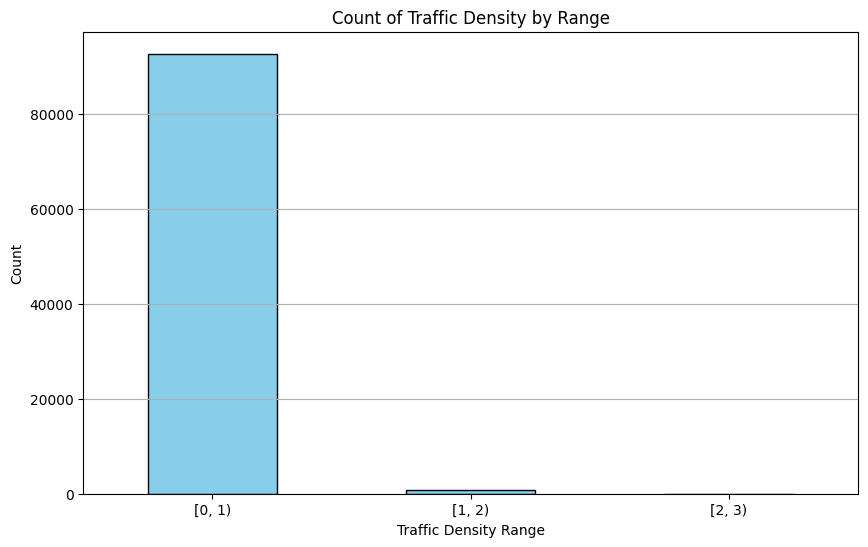

In [16]:
# Plot a bar plot
# Count occurrences in each bin
counts = pd.cut(df['Traffic_Density'], bins=[0, 1, 2, 3], right=False).value_counts().sort_index()
# Create a bar plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Traffic Density by Range')
plt.xlabel('Traffic Density Range')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [17]:
lower_bound = 1
upper_bound = 3

# Remove rows where 'Traffic Density' is in the range [1, 2), [2, 3)
df_filtered = df[~((df['Traffic_Density'] >= lower_bound) & (df['Traffic_Density'] < upper_bound))]


In [18]:
bins = [0, 1, 2, 3]
# Use pd.cut() to bin the data
binned_data = pd.cut(df_filtered['Traffic_Density'], bins=bins, right=False)
# Count occurrences in each bin
count_in_bins = binned_data.value_counts().sort_index()
# Print the result
print(count_in_bins)

Traffic_Density
[0, 1)    92685
[1, 2)        0
[2, 3)        0
Name: count, dtype: int64


In [19]:
df_filtered.shape

(92685, 10)

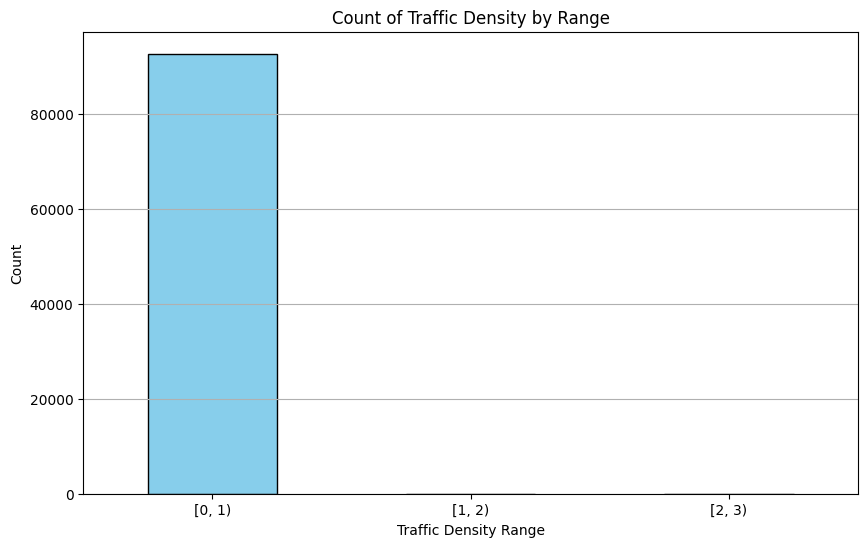

In [20]:
# Plot a bar plot AFTER FILTERING
# Count occurrences in each bin
counts = pd.cut(df_filtered['Traffic_Density'], bins=[0, 1, 2, 3], right=False).value_counts().sort_index()
# Create a bar plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Traffic Density by Range')
plt.xlabel('Traffic Density Range')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<Axes: >

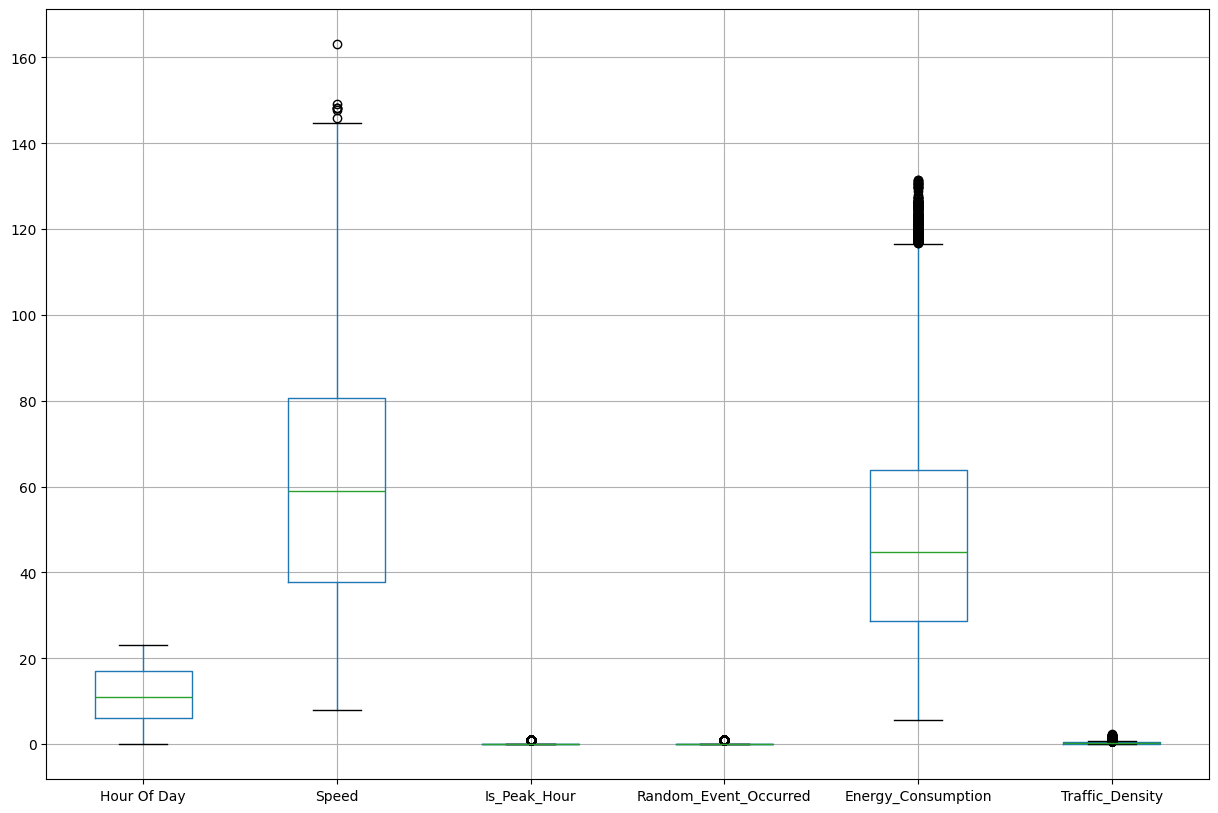

In [21]:
plt.figure(figsize=(15,10))
df.boxplot()

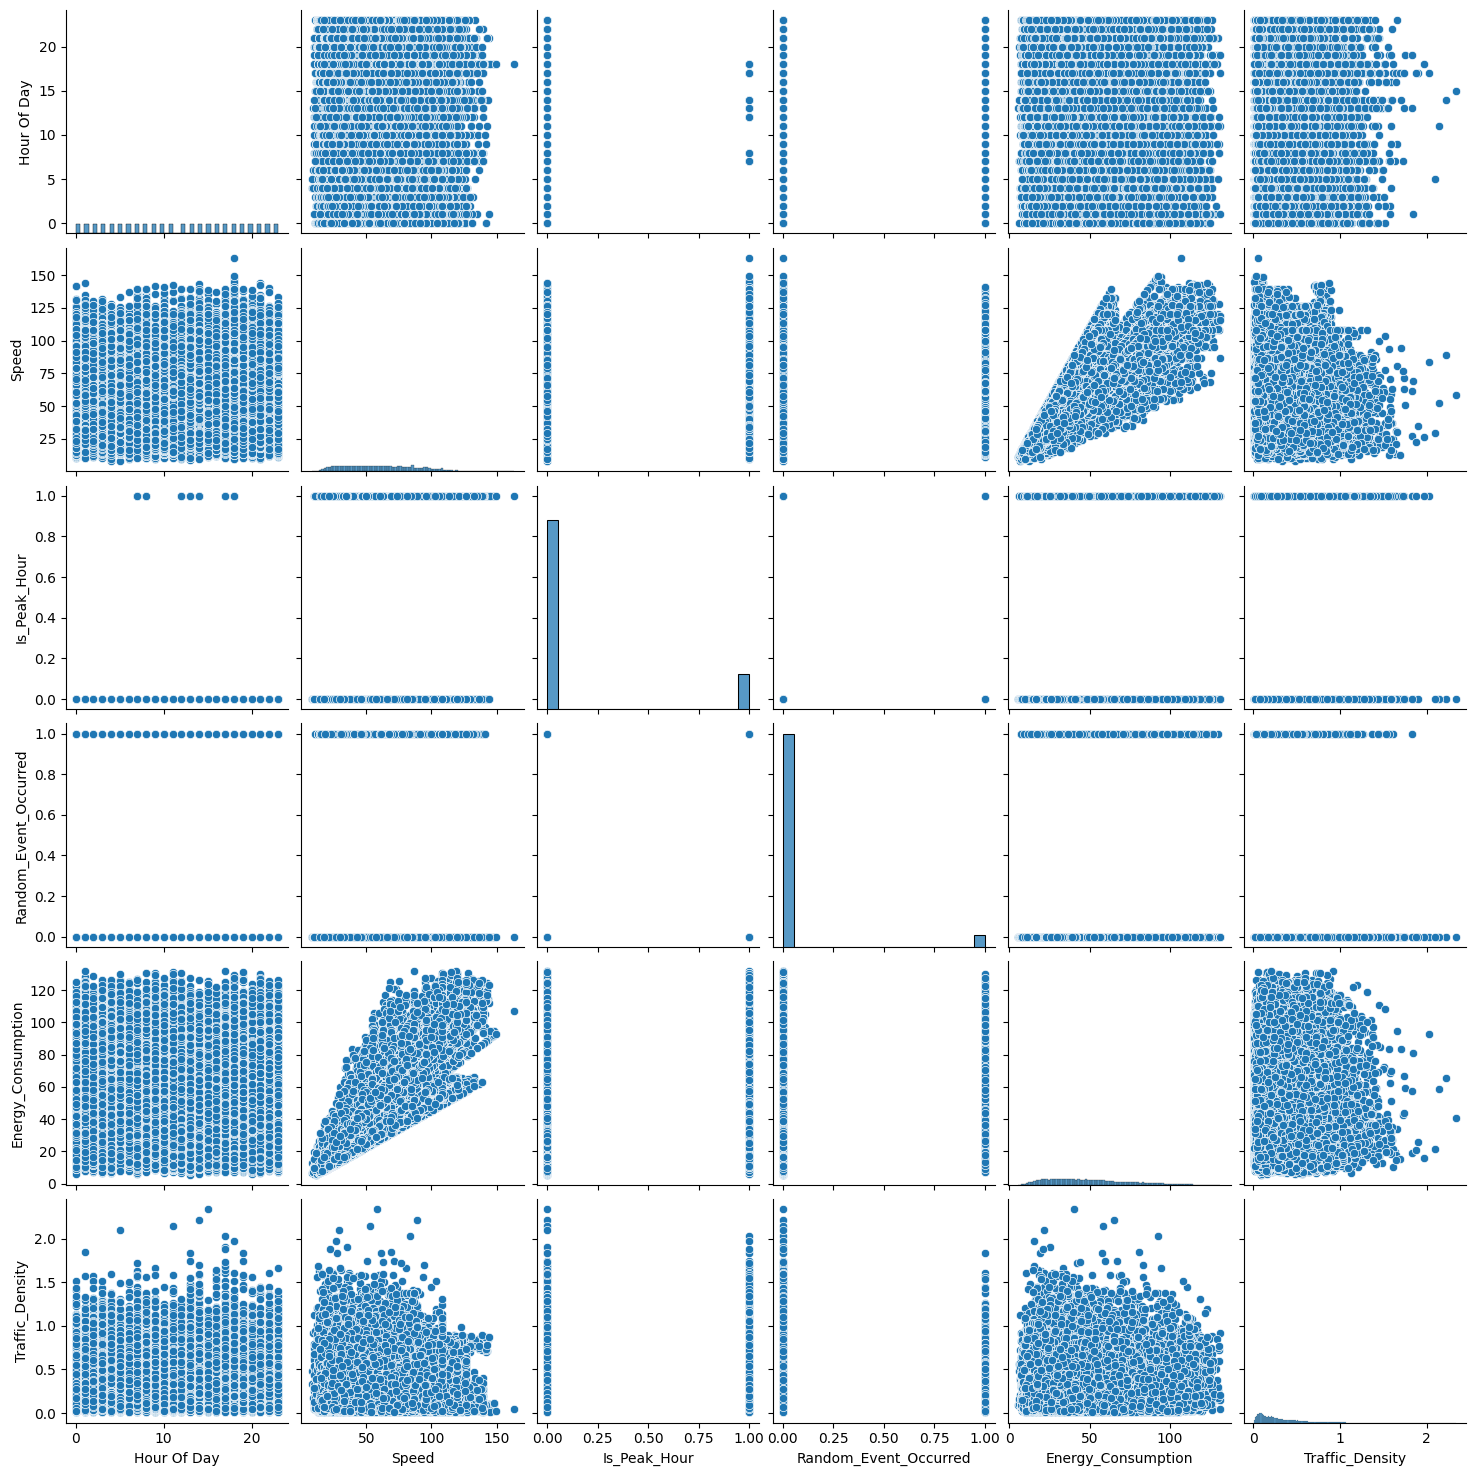

In [22]:
sns.pairplot(df)
plt.show()

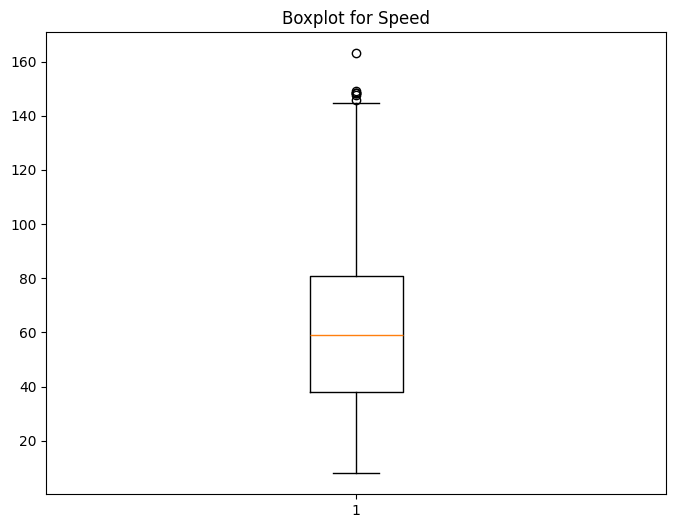

In [23]:
# Boxplot for Speed
plt.figure(figsize=(8, 6))
plt.boxplot(df['Speed'])
plt.title('Boxplot for Speed')
plt.show()

In [24]:
from scipy import stats
# Calculate Z-scores for 'Energy Consumption'
z_scores = stats.zscore(df_filtered['Speed'])

# Define outlier threshold
threshold = 3

# Filter out the outliers
df_filtered = df_filtered[abs(z_scores) < threshold]

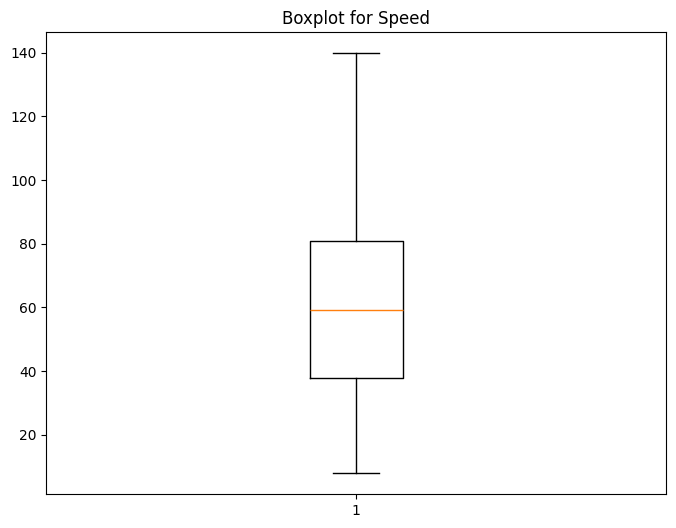

In [25]:
# Boxplot for Speed
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered['Speed'])
plt.title('Boxplot for Speed')
plt.show()

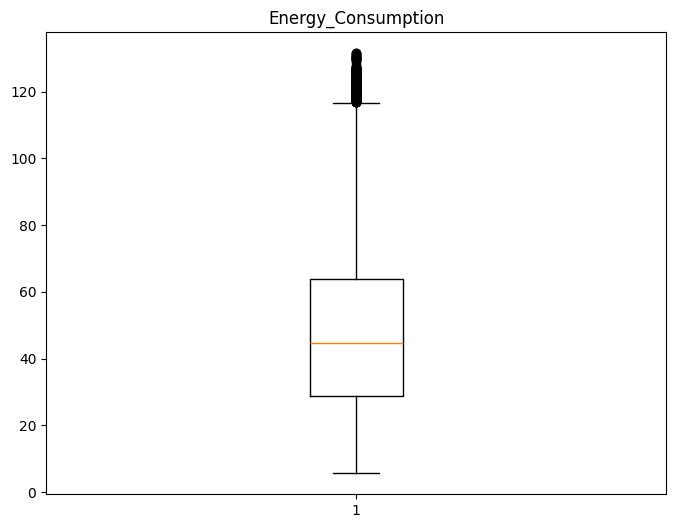

In [26]:
# Boxplot for Speed Before remove the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered['Energy_Consumption'])
plt.title('Energy_Consumption')
plt.show()

In [27]:
from scipy import stats
# Calculate Z-scores for 'Energy Consumption'
z_scores = stats.zscore(df_filtered['Energy_Consumption'])

# Define outlier threshold
threshold = 3

# Filter out the outliers
df_filtered = df_filtered[abs(z_scores) < threshold]

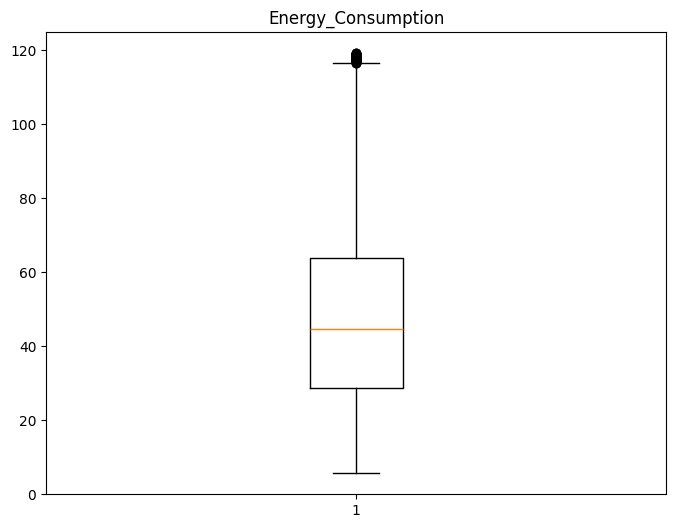

In [28]:
# Boxplot for Speed after remove the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered['Energy_Consumption'])
plt.title('Energy_Consumption')
plt.show()

In [29]:
df_filtered.columns

Index(['City', 'Vehicle_Type', 'Weather', 'Day_Of_Week', 'Hour Of Day',
       'Speed', 'Is_Peak_Hour', 'Random_Event_Occurred', 'Energy_Consumption',
       'Traffic_Density'],
      dtype='object')

In [30]:
# here is the labels

# bins = [0, 0.15, 0.30, 0.99]  # Define bins to fit within 0-1 range
bins = [0, 0.15, 0.30, 0.99]
labels = ['Low', 'Medium', 'High']  # Define labels

# Bin the data and assign labels to the new column
df_filtered['Traffic_Density_Category'] = pd.cut(df_filtered['Traffic_Density'], bins=bins, labels=labels, right=True)

# Print the result
print(df_filtered)

                City        Vehicle_Type                Weather Day_Of_Week  \
0       SolarisVille               Drone                  Snowy      Sunday   
2          Neuroburg  Autonomous Vehicle            Solar Flare   Wednesday   
3          Ecoopolis               Drone                  Clear    Thursday   
4           AquaCity  Autonomous Vehicle            Solar Flare    Saturday   
5          TechHaven  Autonomous Vehicle                  Snowy    Thursday   
...              ...                 ...                    ...         ...   
99996      Neuroburg               Drone                  Clear    Saturday   
99997    MetropolisX               Drone                  Snowy      Monday   
99998    MetropolisX  Autonomous Vehicle                  Clear      Friday   
99999      TechHaven  Autonomous Vehicle  Electromagnetic Storm      Friday   
100000   MetropolisX  Autonomous Vehicle                  Clear   Wednesday   

        Hour Of Day     Speed  Is_Peak_Hour  Random

In [31]:
df_filtered.head()

,City,Vehicle_Type,Weather,Day_Of_Week,Hour Of Day,Speed,Is_Peak_Hour,Random_Event_Occurred,Energy_Consumption,Traffic_Density,Traffic_Density_Category
0,SolarisVille,Drone,Snowy,Sunday,20,29.4268,0,0,14.7134,0.5241,High
2,Neuroburg,Autonomous Vehicle,Solar Flare,Wednesday,16,100.3904,0,0,91.2640,0.0415,Low
3,Ecoopolis,Drone,Clear,Thursday,8,76.8000,1,0,46.0753,0.1811,Medium
4,AquaCity,Autonomous Vehicle,Solar Flare,Saturday,16,45.2176,0,0,40.1934,0.4544,High
5,TechHaven,Autonomous Vehicle,Snowy,Thursday,20,30.5179,0,0,37.5562,0.0843,Low


In [32]:
df_filtered.shape

(92503, 11)

In [33]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92503 entries, 0 to 100000
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   City                      92503 non-null  object  
 1   Vehicle_Type              92503 non-null  object  
 2   Weather                   92503 non-null  object  
 3   Day_Of_Week               92503 non-null  object  
 4   Hour Of Day               92503 non-null  int64   
 5   Speed                     92503 non-null  float64 
 6   Is_Peak_Hour              92503 non-null  int64   
 7   Random_Event_Occurred     92503 non-null  int64   
 8   Energy_Consumption        92503 non-null  float64 
 9   Traffic_Density           92503 non-null  float64 
 10  Traffic_Density_Category  92470 non-null  category
dtypes: category(1), float64(3), int64(3), object(4)
memory usage: 7.9+ MB


# Preprocessing

In [34]:
label_encoder = LabelEncoder()

for column in ['City','Weather',
               'Day_Of_Week','Vehicle_Type']:
    # Fit and transform on df_filtered, not df
    df_filtered[column] = label_encoder.fit_transform(df_filtered[column])


In [35]:
# df_filtered = pd.get_dummies(df_filtered, columns=['Traffic_Density_Category'])

In [36]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92503 entries, 0 to 100000
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   City                      92503 non-null  int64   
 1   Vehicle_Type              92503 non-null  int64   
 2   Weather                   92503 non-null  int64   
 3   Day_Of_Week               92503 non-null  int64   
 4   Hour Of Day               92503 non-null  int64   
 5   Speed                     92503 non-null  float64 
 6   Is_Peak_Hour              92503 non-null  int64   
 7   Random_Event_Occurred     92503 non-null  int64   
 8   Energy_Consumption        92503 non-null  float64 
 9   Traffic_Density           92503 non-null  float64 
 10  Traffic_Density_Category  92470 non-null  category
dtypes: category(1), float64(3), int64(7)
memory usage: 7.9 MB


In [37]:
# features = ['City', 'Vehicle_Type', 'Weather', 'Day_Of_Week',
#             'Hour Of Day', 'Speed', 'Is_Peak_Hour', 'Random_Event_Occurred',
#             'Energy_Consumption']  # Corrected column names
# target = 'Traffic_Density_Category'  # Define the target variable

# # One-hot encode the target variable

# # Verify if the columns exist in df_filtered
# for feature in features:
#     if feature not in df_filtered.columns:
#         print(f"Warning: Column '{feature}' not found in DataFrame.")

# X = df_filtered[features]
# y = df_filtered[target]



In [38]:

X = df_filtered[['City','Day_Of_Week', 'Vehicle_Type', 'Weather','Random_Event_Occurred',
            'Hour Of Day']]
X1=df_filtered[['City','Day_Of_Week','Vehicle_Type','Speed','Is_Peak_Hour',
            'Energy_Consumption']]

target = 'Traffic_Density_Category'  # Define the target variable
y = df_filtered[target]

In [39]:
y = pd.get_dummies(y)

## Train-Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42)

In [42]:
model = Sequential([(Dense(units=6, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu')),
                   (Dense(units=10, activation='relu')),
                    (Dense(units=8, activation='relu')),
                     (Dense(units=9, activation='relu')),
                    (Dense(units=6, activation='relu')),
            (Dense(units=3, activation='softmax'))


              ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model1 = Sequential([(Dense(units=6, input_dim=X_train1.shape[1], kernel_initializer='uniform', activation='relu')),
                   (Dense(units=10, activation='relu')),
                    (Dense(units=8, activation='relu')),
                     (Dense(units=9, activation='relu')),
                     (Dense(units=6, activation='relu')),
            (Dense(units=3, activation='softmax'))


              ])

In [44]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
#compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 362 (1.41 KB)

 Trainable params: 362 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 362 (1.41 KB)

 Trainable params: 362 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

Epoch 1/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4056 - loss: 1.0744 - val_accuracy: 0.4883 - val_loss: 0.9519
Epoch 2/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5389 - loss: 0.9090 - val_accuracy: 0.5527 - val_loss: 0.8662
Epoch 3/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5892 - loss: 0.8382 - val_accuracy: 0.6004 - val_loss: 0.8086
Epoch 4/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6126 - loss: 0.8033 - val_accuracy: 0.5987 - val_loss: 0.8090
Epoch 5/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6402 - loss: 0.7889 - val_accuracy: 0.6389 - val_loss: 0.7913
Epoch 6/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6464 - loss: 0.7854 - val_accuracy: 0.6506 - val_loss: 0.7804
Epoch 7/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6475 - loss: 0.7818 - val_accuracy: 0.6451 - val_loss: 0.7864
Epoch 8/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6498 - loss: 0.7775 - 

In [49]:
history = model1.fit(X_train1, y_train1, batch_size=50, epochs=50, validation_split=0.2)


Epoch 1/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3846 - loss: 1.0859 - val_accuracy: 0.4627 - val_loss: 1.0260
Epoch 2/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4739 - loss: 1.0145 - val_accuracy: 0.4713 - val_loss: 0.9771
Epoch 3/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5047 - loss: 0.9709 - val_accuracy: 0.5246 - val_loss: 0.9388
Epoch 4/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5363 - loss: 0.9219 - val_accuracy: 0.5532 - val_loss: 0.8713
Epoch 5/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5679 - loss: 0.8621 - val_accuracy: 0.6193 - val_loss: 0.8153
Epoch 6/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6161 - loss: 0.8199 - val_accuracy: 0.6212 - val_loss: 0.8063
Epoch 7/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6279 - loss: 0.8112 - val_accuracy: 0.6290 - val_loss: 0.8191
Epoch 8/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6280 - loss: 0.8056 - 

In [50]:
from sklearn.metrics import classification_report

# Predict classes
predictions = model.predict(X_test)
y_pred = predictions.argmax(axis=1)
if y_test.ndim == 2:  # Check if y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.50      0.64      6782
           1       0.50      0.60      0.55      5353
           2       0.66      0.86      0.75      6366

    accuracy                           0.65     18501
   macro avg       0.69      0.66      0.65     18501
weighted avg       0.71      0.65      0.65     18501



In [51]:
from sklearn.metrics import classification_report

# Predict classes
predictions = model.predict(X_test1)
y_pred1 = predictions.argmax(axis=1)
if y_test1.ndim == 2:  # Check if y_test is one-hot encoded
    y_test1 = np.argmax(y_test1, axis=1)

# Generate classification report
report = classification_report(y_test1, y_pred1)
print(report)

579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.34      0.46      0.39      6782
           1       0.30      0.43      0.36      5353
           2       0.25      0.07      0.11      6366

    accuracy                           0.32     18501
   macro avg       0.30      0.32      0.29     18501
weighted avg       0.30      0.32      0.28     18501



In [52]:
from sklearn.metrics import classification_report

# Predict classes
predictions = model.predict(X_train)
y_pred = predictions.argmax(axis=1)
if y_train.ndim == 2:  # Check if y_test is one-hot encoded
    y_train = np.argmax(y_train, axis=1)

# Generate classification report
report = classification_report(y_train, y_pred)
print(report)

2313/2313 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.49      0.64     27482
           1       0.49      0.61      0.55     21225
           2       0.66      0.86      0.75     25295

    accuracy                           0.65     74002
   macro avg       0.69      0.66      0.65     74002
weighted avg       0.71      0.65      0.65     74002



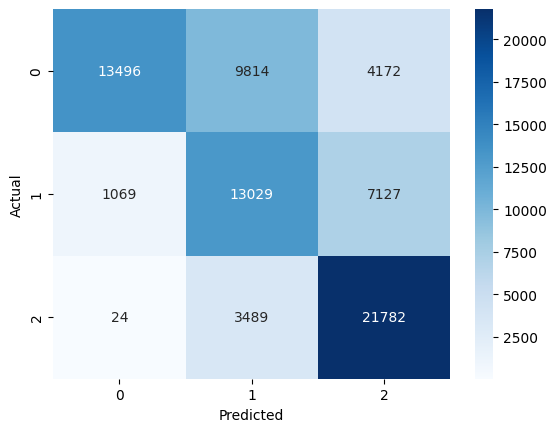

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

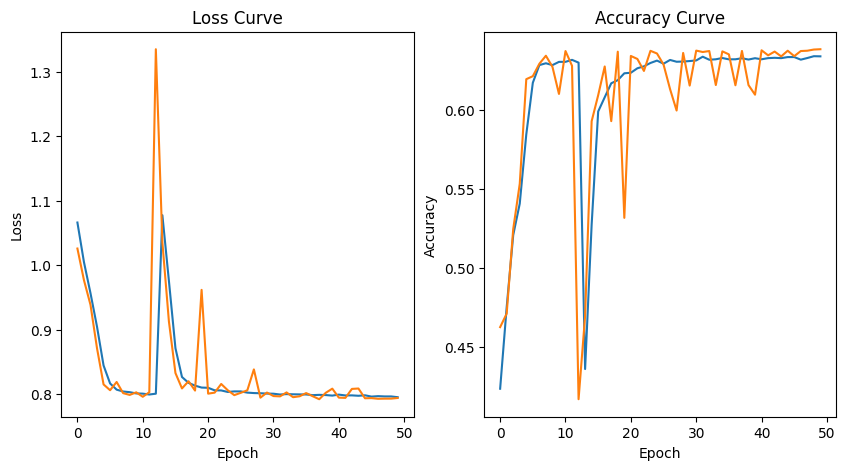

In [54]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')

plt.show()

In [55]:
df_filtered.columns

Index(['City', 'Vehicle_Type', 'Weather', 'Day_Of_Week', 'Hour Of Day',
       'Speed', 'Is_Peak_Hour', 'Random_Event_Occurred', 'Energy_Consumption',
       'Traffic_Density', 'Traffic_Density_Category'],
      dtype='object')

In [56]:
df_filtered['Traffic_Density_Category'].value_counts()

,count
Traffic_Density_Category,
Low,34231
High,31661
Medium,26578


In [57]:
encoder = OneHotEncoder()
y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

# Now evaluate the model
model.evaluate(X_test, y_test_encoded)

579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6548 - loss: 0.7715


[0.770948588848114, 0.6547213792800903]

## Modeling

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.65      0.63      6782
           1       0.42      0.39      0.40      5353
           2       0.66      0.65      0.65      6366

    accuracy                           0.57     18501
   macro avg       0.56      0.56      0.56     18501
weighted avg       0.57      0.57      0.57     18501



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.77      0.58      6782
           1       0.00      0.00      0.00      5353
           2       0.47      0.53      0.50      6366

    accuracy                           0.47     18501
   macro avg       0.31      0.43      0.36     18501
weighted avg       0.33      0.47      0.38     18501

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      6782
           1       0.43      0.39      0.41      5353
           2       0.65      0.68      0.67      6366

    accuracy                           0.59     18501
   macro avg       0.57      0.58      0.57     18501
weighted avg       0.58      0.59      0.58     18501

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65      6782
           1       0.45  

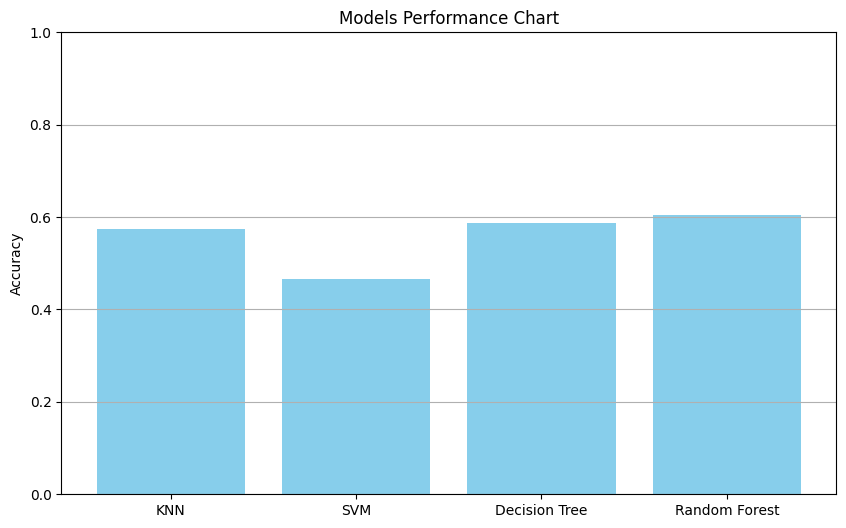

In [58]:

# Import the KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# تدريب وتقييم كل نموذج
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"{name} Classification Report:\n", classification_report(y_test, predictions))

def plot_model_accuracy(results):
    model_names = list(results.keys())
    accuracies = list(results.values())


    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Models Performance Chart')
    plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
    plt.grid(axis='y')
    plt.show()

plot_model_accuracy(results)


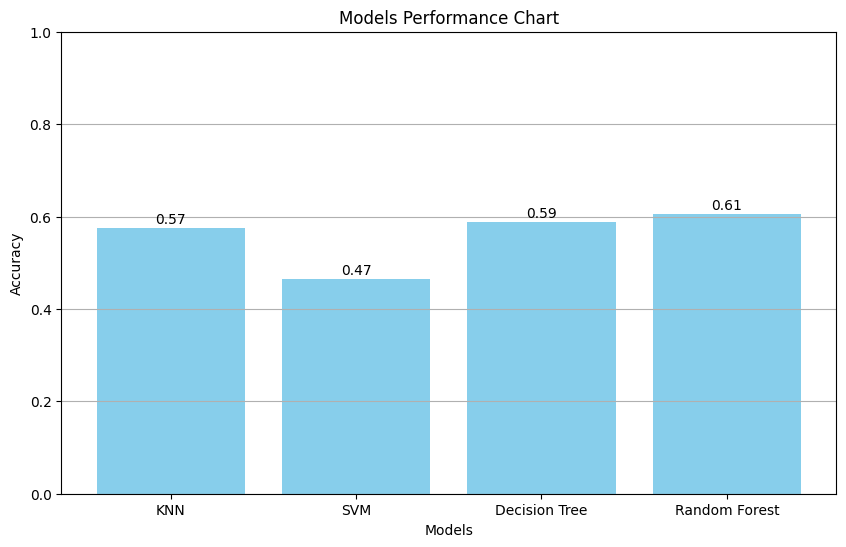

In [59]:

def plot_model_accuracy(results):
    model_names = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='skyblue')
    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    plt.title('Models Performance Chart')
    plt.ylim(0, 1)  # ضبط نطاق الدقة بين 0 و 1
    plt.grid(axis='y')

    # إضافة القيم على الأعمدة
    for index, value in enumerate(accuracies):
        plt.text(index, value + 0.01, f"{value:.2f}", ha='center')

    plt.show()

# رسم الأداء
plot_model_accuracy(results)



Model: J48 (Decision Tree)
  Accuracy: 0.5874
  Precision: 0.5723
  F1 Score: 0.5733
  Error Rate: 0.4126

Model: Naive Bayes
  Accuracy: 0.4532
  Precision: 0.4572
  F1 Score: 0.3775
  Error Rate: 0.5468

Model: KNN
  Accuracy: 0.5743
  Precision: 0.5615
  F1 Score: 0.5617
  Error Rate: 0.4257

Model: SVM
  Accuracy: 0.4414
  Precision: 0.4465
  F1 Score: 0.4256
  Error Rate: 0.5586



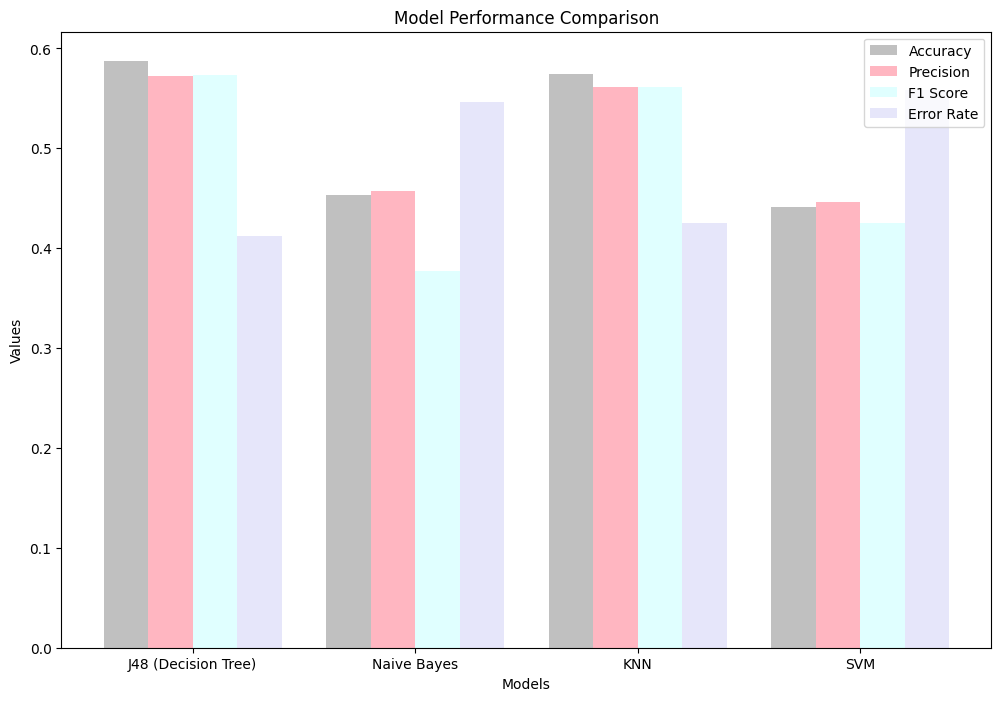

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

results = {}

def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

models = {
    "J48 (Decision Tree)": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

for model_name, model in models.items():

    model.fit(X_train, y_train)

    # التنبؤ بالقيم
    y_pred = model.predict(X_test)

    # حساب المقاييس
    acc = accuracy_score(y_test, y_pred)

    # تغيير 'average' إلى 'macro' أو 'weighted' للتعامل مع التصنيف متعدد الفئات
    precision = precision_score(y_test, y_pred, average='macro')  # أو 'weighted'
    f1 = f1_score(y_test, y_pred, average='macro')  # أو 'weighted'
    error = error_rate(y_test, y_pred)

    # تخزين النتائج
    results[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "F1 Score": f1,
        "Error Rate": error
    }

# طباعة النتائج
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

# إعداد الرسم البياني
def plot_model_metrics(results):
    model_names = list(results.keys())
    accuracies = [metrics['Accuracy'] for metrics in results.values()]
    precisions = [metrics['Precision'] for metrics in results.values()]
    f1_scores = [metrics['F1 Score'] for metrics in results.values()]
    error_rates = [metrics['Error Rate'] for metrics in results.values()]

    # إعداد الرسم البياني متعدد
    plt.figure(figsize=(12, 8))

    # رسم كل مقياس على حدة
    x = np.arange(len(model_names))  # مواقع النماذج على المحور الأفقي
    width = 0.2  # عرض الأعمدة

    plt.bar(x - width*1.5, accuracies, width, label='Accuracy', color='silver')
    plt.bar(x - width*0.5, precisions, width, label='Precision', color='lightpink')
    plt.bar(x + width*0.5, f1_scores, width, label='F1 Score', color='lightcyan')
    plt.bar(x + width*1.5, error_rates, width, label='Error Rate', color='lavender')

    plt.xlabel('Models')
    plt.ylabel('Values')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()

    plt.show()

plot_model_metrics(results)


Decision Tree: Acc=0.587, Prec=0.572, F1=0.573, Err=0.413


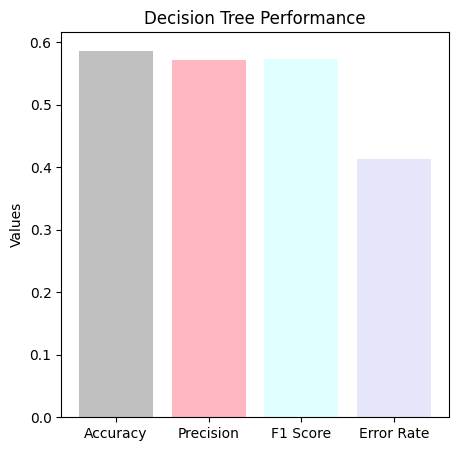

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
error = 1 - acc

print(f"Decision Tree: Acc={acc:.3f}, Prec={precision:.3f}, F1={f1:.3f}, Err={error:.3f}")

plt.figure(figsize=(5, 5))
plt.bar(['Accuracy', 'Precision', 'F1 Score', 'Error Rate'], [acc, precision, f1, error], color=['silver', 'lightpink', 'lightcyan', 'lavender'])
plt.title('Decision Tree Performance')
plt.ylabel('Values')
plt.show()


Naive Bayes: Acc=0.453, Prec=0.457, F1=0.377, Err=0.547


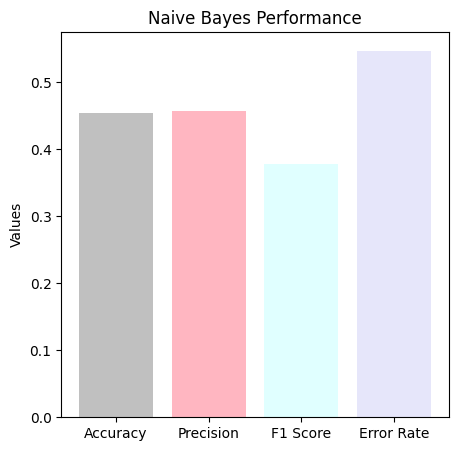

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, f1_score

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
error = 1 - acc

print(f"Naive Bayes: Acc={acc:.3f}, Prec={precision:.3f}, F1={f1:.3f}, Err={error:.3f}")

plt.figure(figsize=(5, 5))
plt.bar(['Accuracy', 'Precision', 'F1 Score', 'Error Rate'], [acc, precision, f1, error], color=['silver', 'lightpink', 'lightcyan', 'lavender'])
plt.title('Naive Bayes Performance')
plt.ylabel('Values')
plt.show()


KNN: Acc=0.574, Prec=0.561, F1=0.562, Err=0.426


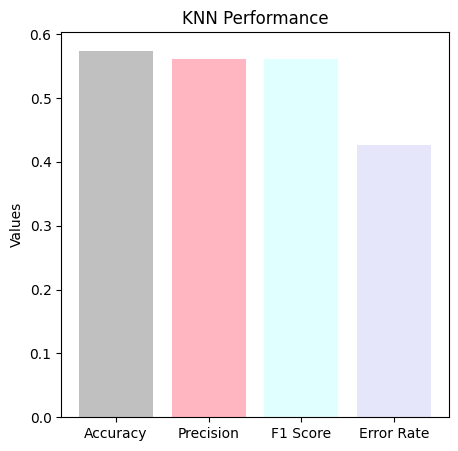

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
error = 1 - acc

print(f"KNN: Acc={acc:.3f}, Prec={precision:.3f}, F1={f1:.3f}, Err={error:.3f}")

plt.figure(figsize=(5, 5))
plt.bar(['Accuracy', 'Precision', 'F1 Score', 'Error Rate'], [acc, precision, f1, error], color=['silver', 'lightpink', 'lightcyan', 'lavender'])
plt.title('KNN Performance')
plt.ylabel('Values')
plt.show()


SVM: Acc=0.441, Prec=0.447, F1=0.426, Err=0.559


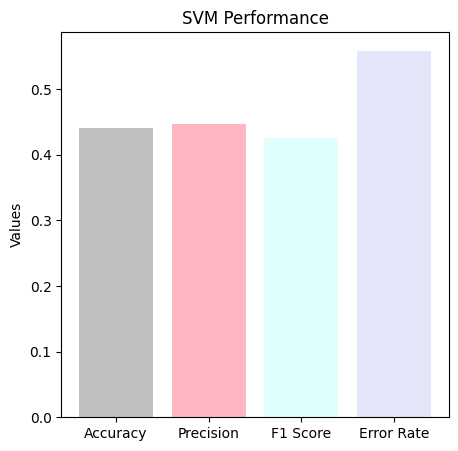

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
error = 1 - acc


print(f"SVM: Acc={acc:.3f}, Prec={precision:.3f}, F1={f1:.3f}, Err={error:.3f}")

plt.figure(figsize=(5, 5))
plt.bar(['Accuracy', 'Precision', 'F1 Score', 'Error Rate'], [acc, precision, f1, error], color=['silver', 'lightpink', 'lightcyan', 'lavender'])
plt.title('SVM Performance')
plt.ylabel('Values')
plt.show()


Model Performance Summary:
J48 (Decision Tree): Acc=0.587, Prec=0.572, F1=0.573, Err=0.413
Naive Bayes: Acc=0.453, Prec=0.457, F1=0.377, Err=0.547
KNN: Acc=0.574, Prec=0.561, F1=0.562, Err=0.426
SVM: Acc=0.441, Prec=0.447, F1=0.426, Err=0.559


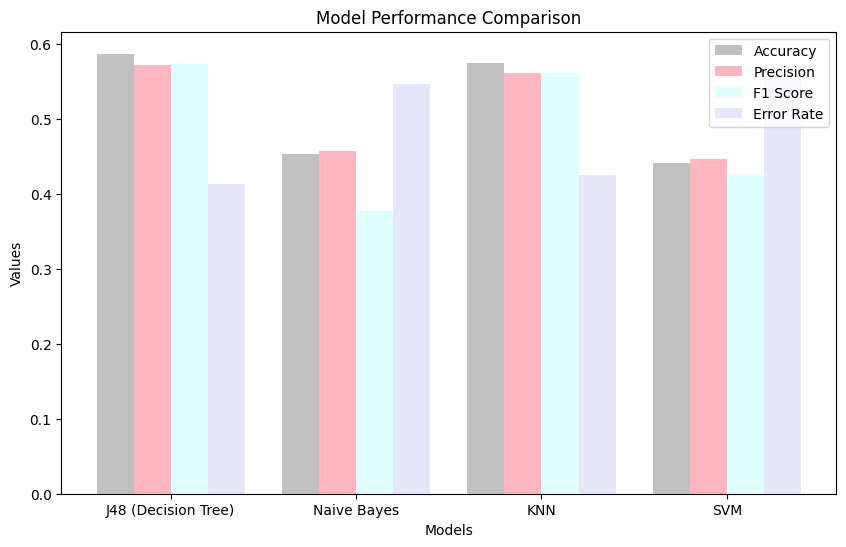

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  # لجعل نموذج J48
from sklearn.naive_bayes import GaussianNB  # لنموذج Naive Bayes
from sklearn.neighbors import KNeighborsClassifier  # لنموذج KNN
from sklearn.svm import SVC  # لنموذج SVM
from sklearn.metrics import accuracy_score, precision_score, f1_score

# تخزين الدقة لكل نموذج
results = {}

# دالة لحساب معدل الأخطاء (Error Rate)
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

# تدريب واختبار كل نموذج
models = {
    "J48 (Decision Tree)": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

for model_name, model in models.items():
    # تدريب النموذج
    model.fit(X_train, y_train)

    # التنبؤ بالقيم
    y_pred = model.predict(X_test)

    # حساب المقاييس
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # أو 'weighted'
    f1 = f1_score(y_test, y_pred, average='macro')  # أو 'weighted'
    error = error_rate(y_test, y_pred)

    # تخزين النتائج
    results[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "F1 Score": f1,
        "Error Rate": error
    }

# طباعة النتائج بشكل مختصر
print("Model Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: Acc={metrics['Accuracy']:.3f}, Prec={metrics['Precision']:.3f}, F1={metrics['F1 Score']:.3f}, Err={metrics['Error Rate']:.3f}")

# إعداد الرسم البياني
def plot_model_metrics(results):
    model_names = list(results.keys())
    accuracies = [metrics['Accuracy'] for metrics in results.values()]
    precisions = [metrics['Precision'] for metrics in results.values()]
    f1_scores = [metrics['F1 Score'] for metrics in results.values()]
    error_rates = [metrics['Error Rate'] for metrics in results.values()]

    # إعداد الرسم البياني متعدد
    plt.figure(figsize=(10, 6))

    # رسم كل مقياس على حدة
    x = np.arange(len(model_names))  # مواقع النماذج على المحور الأفقي
    width = 0.2  # عرض الأعمدة


    plt.bar(x - width*1.5, accuracies, width, label='Accuracy', color='silver')
    plt.bar(x - width*0.5, precisions, width, label='Precision', color='lightpink')
    plt.bar(x + width*0.5, f1_scores, width, label='F1 Score', color='lightcyan')
    plt.bar(x + width*1.5, error_rates, width, label='Error Rate', color='lavender')


    plt.xlabel('Models')
    plt.ylabel('Values')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()

    plt.show()

# رسم الأداء
plot_model_metrics(results)
